# Exploratory Data Analysis (EDA) on USDA HPAI Detections in Wild Birds

## Introduction

### Purpose
This notebook performs an Exploratory Data Analysis (EDA) on Highly Pathogenic Avian Influenza (HPAI) detections in wild birds. The goals are to:
- Understand the structure and characteristics of the dataset.
- Identify and address missing or inconsistent data.
- Visualize trends over time, geography, and bird species.
- Provide insights into the spread of HPAI across the U.S.

### Data Source
The dataset is publicly available through the USDA:
- [USDA HPAI Wild Birds Detections](https://www.aphis.usda.gov/livestock-poultry-disease/avian/avian-influenza/hpai-detections/wild-birds)
- Format: CSV
- Contains fields such as:
  - `state`, `county`, `collection_date`, `date_detected`, `hpai_strain`, `bird_species`, `woah_classification`, `sampling_method`, and `submitting_agency`.

### About the Data
Each row represents a unique detection event. No duplicates were removed during cleaning because multiple detections may occur at the same location and date.

### Process Overview
1. Acquire the dataset via automated script.
2. Compare the automated download to a manually downloaded CSV (one-time validation).
3. Clean and standardize data types and missing values.
4. Perform visualizations to answer the following questions:
   - How have detections changed over time?
   - Which bird species are most affected?
   - Which states report the highest detections?

---

## 1. Data Acquisition

### Automated Download

This notebook retrieves the latest USDA dataset directly using the URL found via browser inspection tools.

>**One-Time Validation:** For quality assurance, the notebook includes an optional comparison between the automated and manually downloaded CSV files.

### Manual Download (Optional)

To manually download the dataset:
1. Go to the [USDA Wild Birds HPAI page](https://www.aphis.usda.gov/livestock-poultry-disease/avian/avian-influenza/hpai-detections/wild-birds)
2. Scroll down and click the blue CSV button.
3. Save the file to `data/manual_usda_hpai_detections_wild_birds.csv` in this repo.

## 2. Setup and Imports

This section imports the required libraries for data analysis, visualization, and dataset validation.

In [74]:
# Import Libraries

# Data handling
import pandas as pd
from io import StringIO
import requests

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Data validation
from pandas.testing import assert_frame_equal


### Load Dataset From USDA Website

This step uses the direct CSV link obtained using the browser’s Inspect tool to automatically retrieve the latest dataset.

In [76]:
# Automate CSV Download From USDA Website 

# Found csv url using the browser's inspect tool
csv_url = "https://www.aphis.usda.gov/sites/default/files/hpai-wild-birds.csv"

# Download and read csv
try:
    download = requests.get(csv_url) # Asks website for file
    download.raise_for_status()  # Show error if download is not successful
    flu_data = pd.read_csv(StringIO(download.text)) # Load the CSV as a table
    print("CSV successfully loaded from USDA website")
    display(flu_data.head())
except Exception as e: # Will catch problem if something goes wrong
    print(f"Failed to load csv from url: {e}")

CSV successfully loaded from USDA website


,State,County,Collection Date,Date Detected,HPAI Strain,Bird Species,WOAH Classification,Sampling Method,Submitting Agency
0,South Carolina,Colleton,12/30/2021,1/13/2022,EA H5N1,American wigeon,Wild bird,Hunter harvest,NWDP
1,South Carolina,Colleton,12/30/2021,1/13/2022,EA H5N1,Blue-winged teal,Wild bird,Hunter harvest,NWDP
2,North Carolina,Hyde,12/30/2021,1/12/2022,EA H5N1,Northern shoveler,Wild bird,Hunter harvest,NWDP
3,North Carolina,Hyde,1/8/2022,1/20/2022,EA H5N1,American wigeon,Wild bird,Hunter harvest,NWDP
4,North Carolina,Hyde,1/8/2022,1/20/2022,EA H5,Gadwall,Wild bird,Hunter harvest,NWDP


### One-Time Validation Step (Optional)

If you manually downloaded the CSV file, this step compares it to the automated version to ensure the automation logic is working correctly.

In [77]:
# Load manually downloaded version
csv_manual = pd.read_csv("data/manual_usda_hpai_detections_wild_birds.csv")

# Normalize both dataframes for comparison
def normalize(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    return df.applymap(lambda x: str(x).strip().lower() if isinstance(x, str) else x)

manual_norm = normalize(csv_manual)
auto_norm = normalize(flu_data)

# Compare normalized versions
try:
    assert_frame_equal(manual_norm, auto_norm, check_like=True)
    print("Automated CSV matches manual download. Validation successful.")
except AssertionError as e:
    print("CSVs are different. Details:")
    print(e)


Automated CSV matches manual download. Validation successful.


## 3. Initial Data Inspection

Before performing any cleaning, this section explores the raw dataset to understand:

- Column data types and non-null counts
- Summary statistics
- Missing values
- Original column names

In [85]:
# Check data types and counts
flu_data.info()

# Display summary statistics for all columns
flu_data.describe(include="all")

# Check for missing values
print("\nMissing values by column:")
print(flu_data.isnull().sum())

# Inspect column names
print("\n Original column names:")
print(flu_data.columns.tolist())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13324 entries, 0 to 13323
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   state                13324 non-null  object
 1   county               13324 non-null  object
 2   collection_date      13324 non-null  object
 3   date_detected        13323 non-null  object
 4   hpai_strain          13323 non-null  object
 5   bird_species         13324 non-null  object
 6   woah_classification  13324 non-null  object
 7   sampling_method      13300 non-null  object
 8   submitting_agency    13324 non-null  object
dtypes: object(9)
memory usage: 937.0+ KB

Missing values by column:
state                   0
county                  0
collection_date         0
date_detected           1
hpai_strain             1
bird_species            0
woah_classification     0
sampling_method        24
submitting_agency       0
dtype: int64

 Original column names:
['state', 'c

In [86]:
# Standardize column names: lowercase, replace spaces with underscores
flu_data.columns = (
    flu_data.columns
    .str.strip()           # Remove leading/trailing spaces
    .str.lower()           # Convert to lowercase
    .str.replace(' ', '_') # Replace spaces with underscores
    .str.replace('(', '')  # Remove parentheses
    .str.replace(')', '')  # Remove parentheses
)

# Check updated column names
print("Updated column names:")
print(flu_data.columns.tolist())

Updated column names:
['state', 'county', 'collection_date', 'date_detected', 'hpai_strain', 'bird_species', 'woah_classification', 'sampling_method', 'submitting_agency']


In [90]:
# Convert 'collection_date' and 'date_detected' to datetime format
flu_data['collection_date'] = pd.to_datetime(flu_data['collection_date'], errors='coerce')
flu_data['date_detected'] = pd.to_datetime(flu_data['date_detected'], errors='coerce')

# Confirm changes
print("\nUpdated data types:")
print(flu_data.dtypes[['collection_date', 'date_detected']])



Updated data types:
collection_date    datetime64[ns]
date_detected      datetime64[ns]
dtype: object


In [94]:
# Check for missing values
print("\nMissing values (before handling):")
print(flu_data.isnull().sum())

# Fill missing values in 'hpai_strain' with 'Unknown'
if 'hpai_strain' in flu_data.columns:
    flu_data['hpai_strain'] = flu_data['hpai_strain'].fillna('Unknown')

# Fill other missing values if needed
flu_data = flu_data.fillna("Unknown")

# Check missing values are corrected
print("\nMissing values (after handling):")
print(flu_data.isnull().sum())



Missing values (before handling):
state                  0
county                 0
collection_date        0
date_detected          0
hpai_strain            0
bird_species           0
woah_classification    0
sampling_method        0
submitting_agency      0
dtype: int64

Missing values (after handling):
state                  0
county                 0
collection_date        0
date_detected          0
hpai_strain            0
bird_species           0
woah_classification    0
sampling_method        0
submitting_agency      0
dtype: int64


In [95]:
# Did not remove duplicates
print("No duplicates were removed because each row represents a valid detection.")

No duplicates were removed because each row represents a valid detection.


In [97]:
# File path to cleaned dataset
cleaned_file_path = "data/cleaned_usda_hpai_wildbirds.csv"  

# Save cleaned dataset as CSV for future use
flu_data.to_csv(data/cleaned_file_path, index=False)

print(f"Cleaned dataset saved as {cleaned_file_path}")

Cleaned dataset saved as cleaned_usda_hpai_wildbirds.csv


## 5. Date Preparation for Time Series Analysis

This section prepares time-based features by:

- Ensuring `date_detected` is in proper datetime format
- Removing rows with invalid or missing dates
- Extracting the year and month for later trend analysis
- Displaying a list of unique years present in the dataset

In [98]:
# Ensure 'date_detected' is in datetime format, coerce invalid entries to handle non-date values (NaT)
flu_data['date_detected'] = pd.to_datetime(flu_data['date_detected'], errors='coerce')

# Drop rows with invalid or missing detection dates
flu_data = flu_data.dropna(subset=['date_detected'])

# Extract the year and month from the 'date_detected' column for year-based grouping
flu_data['year'] = flu_data['date_detected'].dt.year
flu_data['month'] = flu_data['date_detected'].dt.month_name()

# Display all unique years present in the dataset
unique_years = flu_data['year'].dropna().unique()
unique_years.sort()

print("Years in the dataset:", unique_years)

Years in the dataset: [2022 2023 2024 2025]


## 6. Visualizing HPAI Trends Over Time

This section visualizes the number of HPAI detections by date using a time series line plot. This helps identify spikes or seasonal trends in outbreaks over time.

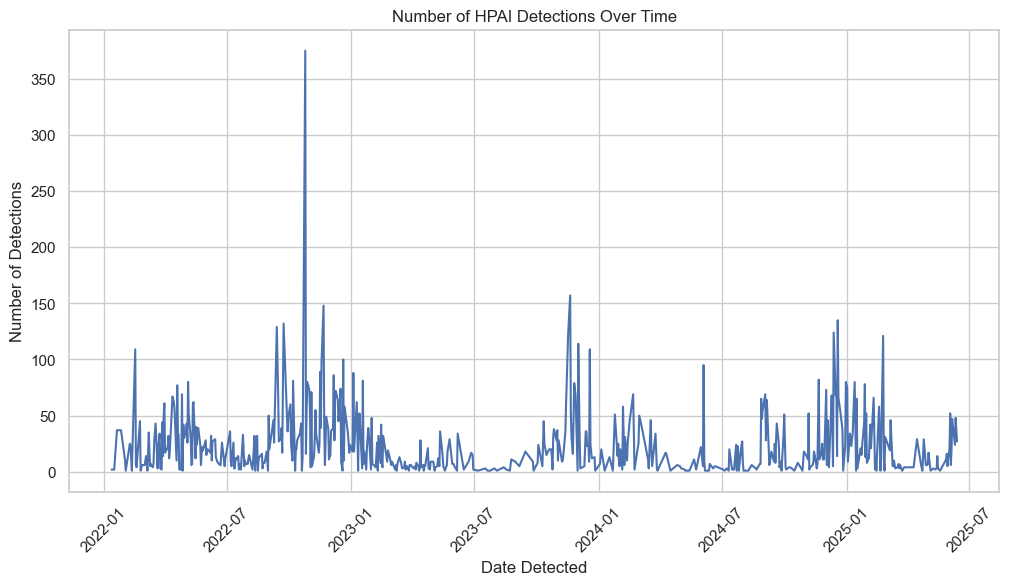

In [99]:
# Create a time series line plot of daily HPAI detections across the dataset
plt.figure(figsize=(12,6))

# Group data by detection date and count number of cases per day
daily_trends = flu_data.groupby('date_detected').size().reset_index(name='detections')

# Plot daily detection trends using seaborn lineplot
sns.lineplot(data=daily_trends, x='date_detected', y='detections')

# Set chart title and axis labels
plt.title("Number of HPAI Detections Over Time")
plt.xlabel("Date Detected")
plt.ylabel("Number of Detections")

# Format x-axis labels to show only year and month and rotate lables for clarity
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as YYYY-MM
plt.xticks(rotation=45)  # Rotate for better readability
plt.grid(True)

#Display the plot
plt.show()


## 7. Top 10 States with HPAI Detections

This bar chart highlights the states that have reported the highest number of HPAI detections. It helps identify geographic hotspots for monitoring and prevention.

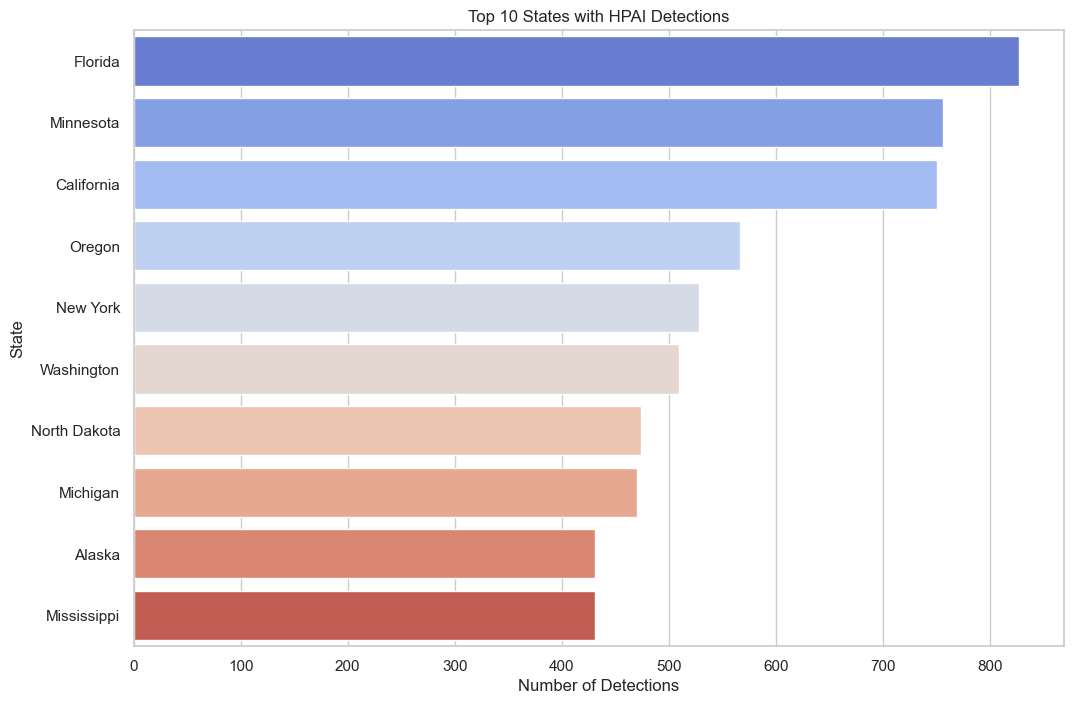

In [100]:
# Count detections per state and select the top 10
state_counts = flu_data['state'].value_counts().head(10)

# Set the figure size for better layout
plt.figure(figsize=(12, 8))

# Build the horizontal bar plot using seaborn
sns.barplot(y=state_counts.index, x=state_counts.values, palette="coolwarm")

# Add chart title and axis labels
plt.title("Top 10 States with HPAI Detections")
plt.xlabel("Number of Detections")
plt.ylabel("State")

# Display the plot
plt.show()


## 8. Top 10 Bird Species with HPAI Detections

This bar chart shows the top 10 bird species with the most confirmed HPAI detections. Identifying which species are most affected provides insight into species-specific vulnerability or sampling focus.

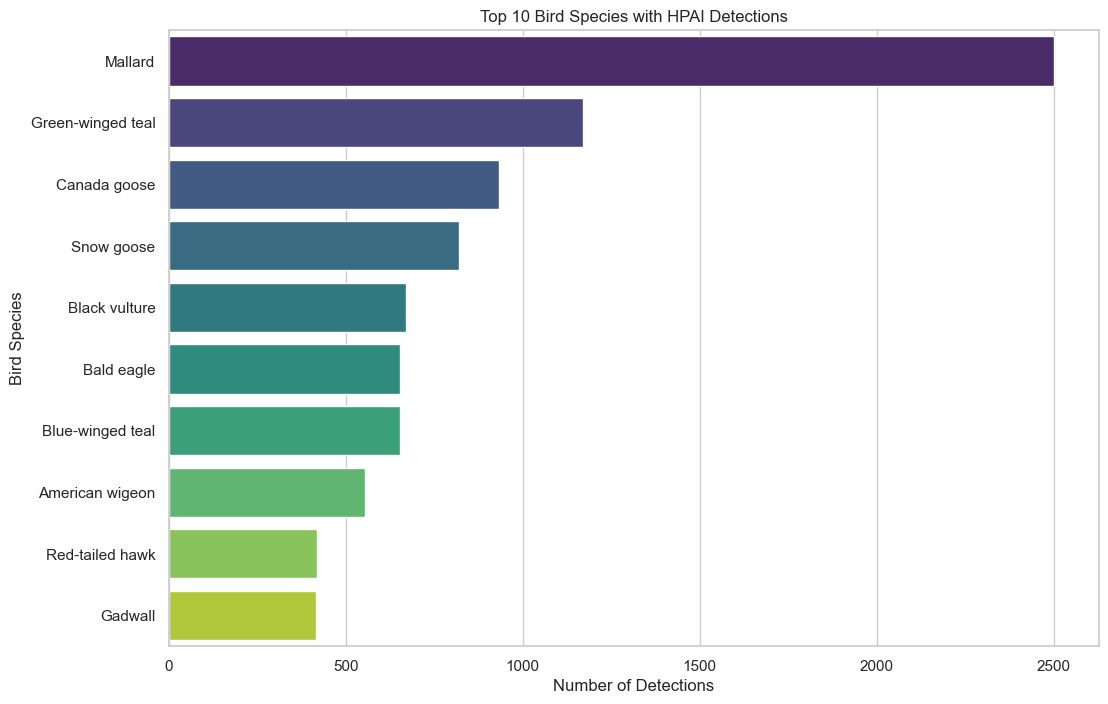

In [101]:
# Count detections by bird species and select the top 10
species_counts = flu_data['bird_species'].value_counts().head(10)

# Set the figure size for readability
plt.figure(figsize=(12, 8))

# Build the horizontal bar plot using index for species names and values for counts
sns.barplot(y=species_counts.index, x=species_counts.values, palette="viridis")

# Add chart title and axis labels
plt.title("Top 10 Bird Species with HPAI Detections")
plt.xlabel("Number of Detections")
plt.ylabel("Bird Species")

# Display the plot
plt.show()


## 9. Monthly Trends in HPAI Detections

This chart displays the total number of HPAI detections by calendar month across all years. Seasonal patterns in bird migration, climate, or surveillance efforts may influence detection volumes.

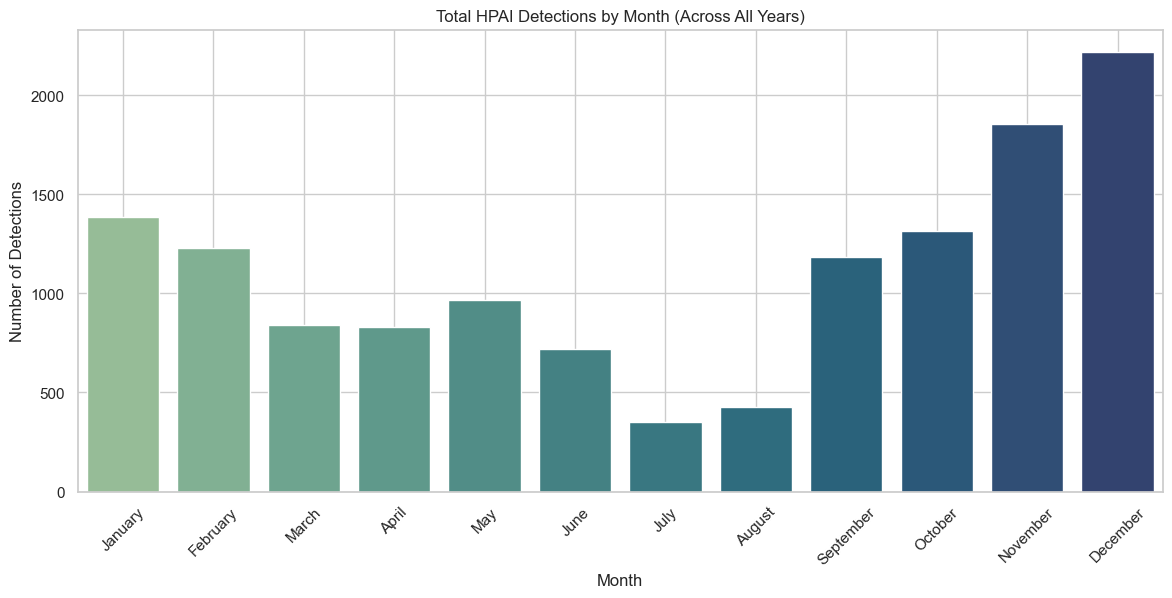

In [102]:
# Extract month name from 'date_detected'
flu_data['month'] = flu_data['date_detected'].dt.month_name()

# Group by month and count detections
monthly_counts = (
    flu_data['month']
    .value_counts()
    .reindex([
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ])  # Ensure calendar order
    .dropna()
)

# Initialize the bar plot
plt.figure(figsize=(14, 6))
sns.barplot(x=monthly_counts.index, y=monthly_counts.values, palette="crest")

# Add chart title and axis labels
plt.title("Total HPAI Detections by Month (Across All Years)")
plt.xlabel("Month")
plt.ylabel("Number of Detections")

# Rotate x-axis labels for readability
plt.xticks(rotation=45)
plt.grid(True)

# Display the plot
plt.show()


## 10. Yearly Detection Trends

This bar plot displays the total number of HPAI detections each year. It helps highlight long-term trends and patterns over time.

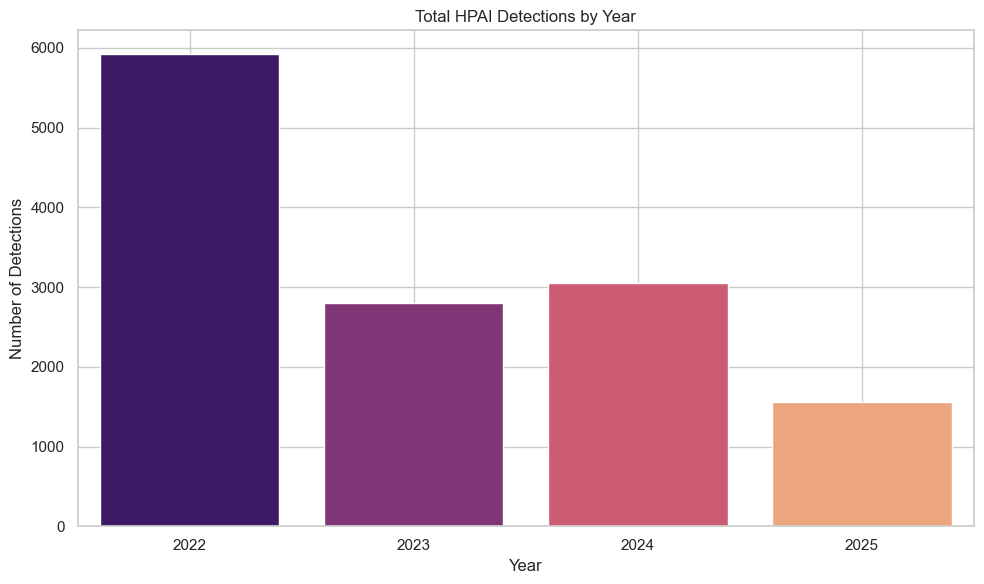

In [103]:
# Count detections per year
yearly_counts = flu_data['year'].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=yearly_counts.index, y=yearly_counts.values, palette="magma")

# Add labels and title
plt.title("Total HPAI Detections by Year")
plt.xlabel("Year")
plt.ylabel("Number of Detections")
plt.grid(True)
plt.tight_layout()
plt.show()


## 11. Heatmap of Detections by Year and Month

This heatmap shows the number of HPAI detections per calendar month across different years. It helps reveal seasonal patterns and year-to-year trends in avian influenza outbreaks.


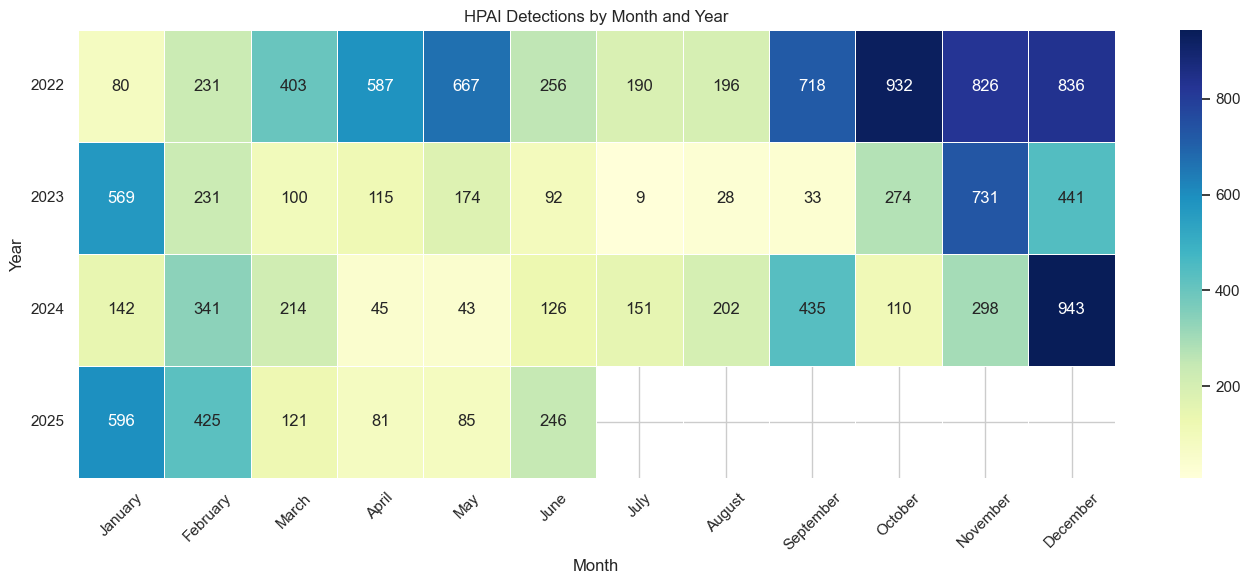

In [110]:
# Extract year and month name for grouping
flu_data['year'] = flu_data['date_detected'].dt.year
flu_data['month'] = flu_data['date_detected'].dt.month_name()

# Create a pivot table with counts
heatmap_data = (
    flu_data.groupby(['year', 'month'])
    .size()
    .reset_index(name='detections')
    .pivot(index='year', columns='month', values='detections')
)

# Reorder months in calendar order
month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]
heatmap_data = heatmap_data[month_order]

# Create the heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", linewidths=0.5, annot=True, fmt=".0f")

plt.title("HPAI Detections by Month and Year")
plt.xlabel("Month")
plt.ylabel("Year")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Conclusion

This exploratory analysis of the USDA's HPAI wild bird detections dataset revealed key trends in virus outbreaks over time, species, geography, and seasonality. By cleaning and visualizing the data, we observed:

- A steady presence of HPAI detections across multiple years.
- Certain bird species and states reporting disproportionately high cases.
- Seasonal peaks suggesting potential cyclical trends.

The visualizations and data preparation in this notebook provide a strong foundation for further investigation or real-time surveillance dashboards.

## Future Work

- **Time Series Modeling:** Use historical data to forecast future detections.
- **Machine Learning:** Classify high-risk species or regions using predictive models.
- **Geo-Mapping:** Create interactive maps using Plotly, PowerBI, or Tableau for spatial insights.
- **Data Automation:** Schedule regular updates via GitHub Actions or a cron job.
- **External Data Integration:** Combine with weather, climate, or migration data to discover deeper correlations.